In [1]:
import os
import glob
import sys
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage import feature, io
from scipy.stats import norm

sys.path.insert(0, '../src')  # Adjust the path as needed
from outliers_removal import outliersOut
from get_image_metrics import measureROIs
from load_files import img_loadr

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# Define the location of the file to read
parent_directory = "/Users/tg2684/Downloads/DIMMERs/microscope-data" # modify if needed
experiment = "08052024_pDIMMERs" # this will be changed for each experiment

# This dictionary defines the folders inside of "experiment" that contain each image type
file_folders = {"image": "MIPs/multi-channel/", 
                "mask_n": "segmentation-masks/nuclei_masks/", 
                "mask_b": "segmentation-masks/background_masks/"}

# This dictionaries will store all image files and their names:
all_images = {"image": [], "mask_n": [], "mask_b": []}
file_names = {"image": [], "mask_n": [], "mask_b": []}
errors = []  # List to store error messages

# Load files with parallel processing using img_loadr() from load_files.py
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
    for f in file_folders:
        # Build the path to the folders indicated at the top
        file_path = os.path.join(parent_directory, experiment, file_folders[f])
        files = glob.glob(os.path.join(file_path, "*.tif"))
        # Run load_image() over the list of files in the folder (files, just above)
        results = executor.map(img_loadr, files)

        for result in results:
            # Unpack the tuples in results, and save the image in all_images[] 
            # and the file names in file_names[]
            image, filename = result
            if image is not None:
                all_images[f].append(image)
                file_names[f].append(filename)

# Log the completion of image processing
if errors:
    logging.error(f"Completed with errors in {len(errors)} files.")
else:
    logging.info("All images and masks have been processed successfully without errors.")

# Optional: Summary of processed files
logging.info(f"Processed {len(file_names['image'])} images, {len(file_names['mask_n'])} nuclei masks, and {len(file_names['mask_b'])} background masks.")

# Now, all_images["image"] contains all the images (MIPs), 
# all_images["mask_n"] contains all the nuclei masks and 
# all_images["mask_b"] contains all the background masks

2024-08-15 15:10:55,012 - INFO - All images and masks have been processed successfully without errors.
2024-08-15 15:10:55,013 - INFO - Processed 67 images, 67 nuclei masks, and 0 background masks.


In [3]:
# Check dimensions of a given set of images, to verify they're correct
test_files = [0, 1]
for f in test_files:
    if f < len(all_images['image']):
        print(f"File {f}:")
        print(all_images['image'][f].shape)
        print(all_images['mask_n'][f].shape)
        #print(all_images['mask_b'][f].shape)
    else:
        print(f"File {f} is out of range.")

File 0:
(3, 2048, 2048)
(2048, 2048)
File 1:
(3, 2048, 2048)
(2048, 2048)


In [4]:
# CHUNK 2 #
# Match image indices to mask indices, to make sure they're paired correctly
# as they may not have been read in the same order

# Assuming file_names['image'] and file_names['mask_n'] contain the file names
image_file_names = file_names['image']
mask_file_names = file_names['mask_n']

# Convert list of mask filenames to a dictionary for faster lookup
mask_name_to_index = {name: idx for idx, name in enumerate(mask_file_names)}

# Match each image with its corresponding mask
matched_indices = []
missing_masks = 0
for img_index, img_name in enumerate(image_file_names):
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"C1-{base_name}_cp_masks.tif"
    mask_index = mask_name_to_index.get(mask_name)

    if mask_index is not None:
        matched_indices.append((img_index, mask_index))
    else:
        missing_masks += 1
        logging.warning(f"No matching mask found for image: {img_name}")

# Log the results of the matching
logging.info(f"Matched {len(matched_indices)} images with masks. Missing masks for {missing_masks} images.")
        
# Now, matched_indices contains pairs of indices for matched image and mask

2024-08-15 15:12:11,173 - INFO - Matched 67 images with masks. Missing masks for 0 images.


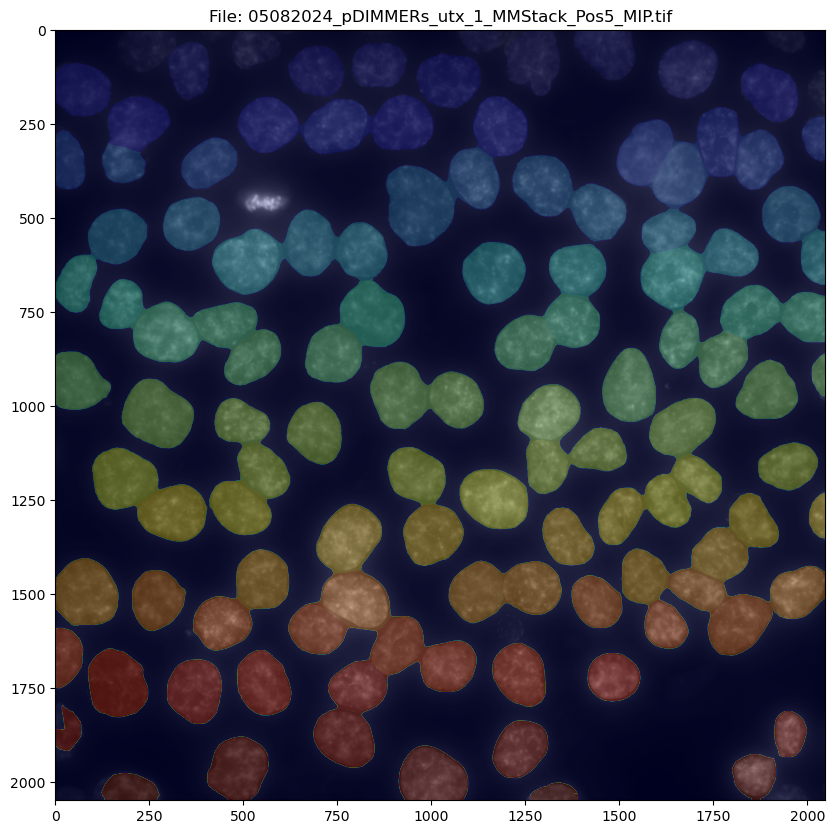

In [5]:
# Overlay the corresponding mask on a channel (given as c) of a given image
# to visually inspect

# Specify the index of the image to check
# and the channel to plot — remember CH1 for ImageJ but channel 0 for Python!
image_index = 38 # Replace with the desired index
c = 0 # remember the channel order in these images

# Find the corresponding mask index
# and define the image and mask pair
mask_index = [pair[1] for pair in matched_indices if pair[0] == image_index][0]

my_image = all_images['image'][image_index]
image_file = file_names['image'][image_index]
my_mask_n = all_images['mask_n'][mask_index]

# Select the c channel
channel_image = my_image[c, ...]

# Overlay the mask on the rest of the image if they have the same dimensions
if channel_image.shape != my_mask_n.shape:
    print("Warning: The image and mask sizes do not match. Please check your data.")
else:
    overlay = np.ma.masked_where(my_mask_n == 0, my_mask_n)
    plt.figure(figsize=(10, 10))
    plt.imshow(channel_image, cmap='gray')  # Display the selected channel in grayscale
    plt.imshow(my_mask_n, cmap='jet', alpha=0.25)  # Overlay the mask with transparency
    plt.title(f'File: {image_file}')
    #plt.axis('off')  # Turn off axis labels
    plt.show()

In [6]:
# Extract a set of metrics for each ROI defined by the mask from the corresponding image
# without doing background subtraction

# Create a dictionary to store metrics for each image
nobs_roi_metrics = {}

# Loop over the matched indices to define the image and mask to utilize
for img_index, mask_index in matched_indices:
    my_image = all_images['image'][img_index]
    my_mask_n = all_images['mask_n'][mask_index]

    # Extract the ID for each of the ROIs — which is their assigned gray level > 0 (0 being the background)
    my_rois = np.unique(my_mask_n)
    my_rois = my_rois[my_rois != 0]
    
    # Dictionary to store metrics for each ROI in each channel of this image
    roi_metrics = {}

    # Iterate over each ROI
    for roi in my_rois:
        roi_metrics[roi] = {}

        # Calculate area of the ROI
        area = np.sum(my_mask_n == roi)
        
        # Iterate over each channel
        for channel_index in range(my_image.shape[0]):
            # Isolate the ROI in this channel
            roi_pixels = my_image[channel_index, my_mask_n == roi]

            # Check if roi_pixels is empty
            if roi_pixels.size == 0:
                print(f"ROI {roi} in Image {img_index}, Channel {channel_index} is empty.")
                continue
                
            # Calculate metrics
            mean_intensity = np.mean(roi_pixels)
            median_intensity = np.median(roi_pixels)
            std_deviation = np.std(roi_pixels)
            max_value = np.max(roi_pixels)
            min_value = np.min(roi_pixels)
            
            # Store metrics
            roi_metrics[roi][f'Channel {channel_index}'] = {
                'area': area,
                'avg': mean_intensity,
                'median': median_intensity,
                'std': std_deviation,
                'maxima': max_value,
                'minima': min_value
            }

    # Store the metrics for this image
    nobs_roi_metrics[f'Image {img_index}'] = roi_metrics

# Now, nobs_roi_metrics contains the metrics for each ROI in each channel for each matched image, 
# without background subraction

In [ ]:
# CHUNK 4 #

# Turn the all_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in all_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X 
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
yesbs_metrics_df = pd.DataFrame(data_rows)

In [ ]:
# CHUNK 4 #

# Turn the all_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in all_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Extract the background intensity for this channel
            bg_intensity = metrics.pop('bg_intensity', None)  # Extract and remove 'bg_intensity' from metrics

            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1]),  # Convert 'Channel X' to integer X
                "background_intensity": bg_intensity  # Add the background intensity as a new column
            }
            row_data.update(metrics)  # Add the remaining metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
yesbs_metrics_df = pd.DataFrame(data_rows)

In [ ]:
# Display the first few rows of the DataFrame to verify it's correct
print(yesbs_metrics_df.head(10))

In [ ]:
# Plot the distribution of ROI areas in the raw data for BG Subtracted data 

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = yesbs_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_original.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [ ]:
# Remove values outside the number of SD that the user defines 
# for the log or sqrt-transformed data, as above
# (2*SD seems generally reasonable for this data)
# using the outliersOut function found in outliers_removal.py
sd_cutoff = 2
tx = "sqrt"

yesbs_filtr_metrics_df, thresholds = outliersOut(yesbs_metrics_df, sd_filter = sd_cutoff, transformation = tx)

# Print the thresholds to verify them
print("Calculated thresholds:")
print(f"Mean: {thresholds[0]}, Std Dev: {thresholds[1]}")
print(f"Lower Threshold: {thresholds[2]}, Upper Threshold: {thresholds[3]}")

# Optionally, display some of the filtered data to inspect the results
print(yesbs_filtr_metrics_df.head())

In [ ]:
# Plot the distribution of ROI areas in the filtered data for BG Subtracted data 

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = yesbs_filtr_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas after removing outliers')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_no-outliers.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [ ]:
# Merge Plasmid Type and Concentration to existing dataframe for BG Subtracted

# Define Experimental Groups csv, label "df2"
experimental_groups = '/Users/tg2684/Downloads/DIMMERs/microscope-data/08052024_pDIMMERs/experimental-groups.csv'
df2 = pd.read_csv(experimental_groups)

# Join previous data frame with df2
yesbs_joined_df = pd.merge(yesbs_filtr_metrics_df, df2, left_on='filename', right_on='filename', how='left')
print(yesbs_joined_df.head())

In [ ]:
# Define the channel you want to plot on the y-axis for the scatter plot
channel_to_plot = 1  # Change this to the desired channel

# Filter the DataFrame for the selected channel
filtered_df = joined_df[joined_df['channel'] == channel_to_plot].copy()

# Apply log2 transformation to the median intensity
filtered_df.loc[:, 'log2_avg'] = np.log2(filtered_df['avg'])


# Prepare background intensity data
background_df = yesbs_scatter_df.copy()
background_df['log2_bg_intensity'] = np.log2(yesbs_scatter_df['bg_intensity'])
background_df = background_df[background_df['bg_intensity'] > 0]  # Exclude non-positive values for log2

# Create the box plot with jittered points
plt.figure(figsize=(12, 6))

# Define the order of plasmid types
plasmid_order = ['none', 'pPGK_NT-EGFP_TLP1c', 'pDIMMER_NT-EGFP_TLP1c_no-miR', 'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR', 'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L', 'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L']  # Replace with actual plasmid types in desired order

# Create the box plot
sns.boxplot(x='plasmid', y='log2_avg', data=filtered_df, palette='Set2', order=plasmid_order)

# Add jittered points for median intensities
sns.stripplot(x='plasmid', y='log2_avg', data=filtered_df, 
              color='green',  # Color of the jitter points
              edgecolor='black',  # Outline color
              linewidth=1,  # Outline width
              alpha=0.7,  # Transparency of the points
              jitter=True, 
              dodge=True,
              order=plasmid_order)

# Add scatter points for background intensities on top
plt.scatter(background_df['plasmid'], background_df['log2_bg_intensity'],
            color='red',  # Color for background intensities
            edgecolor='red',  # Outline color
            linewidth=1,  # Outline width
            alpha=0.7,  # Transparency of the points
            label='Background Intensity',
            zorder=5)  # Ensures points are on top

# Add titles and labels
plt.title(f'{channel_to_plot} Intensity by Plasmid Type')
plt.xlabel('Plasmid Type')
plt.ylabel('Log2 Intensity')

# Define custom labels for the x-axis
custom_labels = {
    'none': 'none',
    'pPGK_NT-EGFP_TLP1c': 'Parental Plasmid',
    'pDIMMER_NT-EGFP_TLP1c_no-miR': 'nomiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR': 'synmiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L': '2x Target DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L': '4x Target DIMMER Plasmid',
    # Add more mappings as needed
}

# Update x-axis labels with custom labels
plt.xticks(ticks=range(len(plasmid_order)), labels=[custom_labels.get(label, label) for label in plasmid_order], rotation=45)

# Add a legend
plt.legend()

# Show plot
plt.show()

In [ ]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Exclude negative values before transforming the metric values to log2
yesbs_hist_filtered_df = yesbs_metrics_df[yesbs_metrics_df[my_metric] > 0].copy()

# Transform the metric values to log2
yesbs_hist_filtered_df['log2_median'] = np.log2(yesbs_hist_filtered_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = yesbs_hist_filtered_df['log2_median'].min()
global_max_intensity = yesbs_hist_filtered_df['log2_median'].max()
max_frequency = yesbs_hist_filtered_df.groupby('channel')[my_metric].count().max()

# Define channel colors
channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in yesbs_hist_filtered_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize=(10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins=150, 
                             color=channel_colors.get(channel, 'gray'), 
                             edgecolor='black', 
                             linewidth=1, 
                             range=(global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()


In [7]:
# CHUNK 4.2 #

# Turn the nobs_roi_metrics dictionary into a Pandas data frame for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in nobs_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
nobs_metrics_df = pd.DataFrame(data_rows)

In [8]:
print(nobs_metrics_df.head())

   image_index                                           filename  \
0            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
1            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
2            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
3            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
4            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   

          experiment  ROI_index  channel   area          avg  median  \
0  08052024_pDIMMERs          1        0  17382  3302.437809  3106.0   
1  08052024_pDIMMERs          1        1  17382   324.945173   324.0   
2  08052024_pDIMMERs          1        2  17382   365.123979   351.0   
3  08052024_pDIMMERs          2        0  13111  3742.484860  3711.0   
4  08052024_pDIMMERs          2        1  13111   301.694989   296.0   

          std  maxima  minima  
0  645.590364    7195    2037  
1   17.322110     488     262  
2   55.899538     724     251  
3  587.373725    5450   

In [9]:
metrics_df = nobs_metrics_df

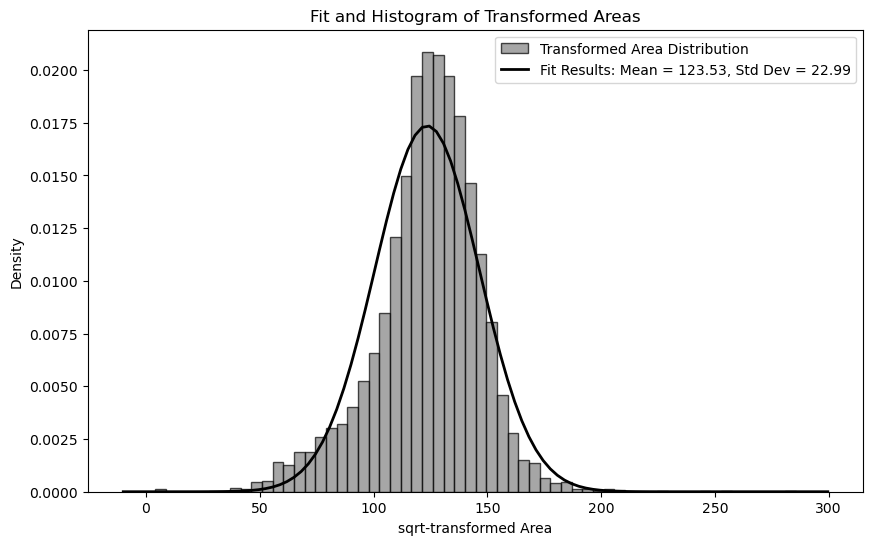

In [10]:
# Plot the distribution of ROI areas in the raw data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_original.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [11]:
# Remove values outside the number of SD that the user defines 
# for the log or sqrt-transformed data, as above
# (2*SD seems generally reasonable for this data)
# using the outliersOut function found in outliers_removal.py
sd_cutoff = 2
tx = "sqrt"

filtr_metrics_df, thresholds = outliersOut(metrics_df, sd_filter = sd_cutoff, transformation = tx)

# Print the thresholds to verify them
print("Calculated thresholds:")
print(f"Mean: {thresholds[0]}, Std Dev: {thresholds[1]}")
print(f"Lower Threshold: {thresholds[2]}, Upper Threshold: {thresholds[3]}")

# Optionally, display some of the filtered data to inspect the results
print(filtr_metrics_df.head())

Calculated thresholds:
Mean: 123.53047887972265, Std Dev: 22.985434044890724
Lower Threshold: 77.5596107899412, Upper Threshold: 169.50134696950408
   image_index                                           filename  \
0            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
1            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
2            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
3            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
4            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   

          experiment  ROI_index  channel   area          avg  median  \
0  08052024_pDIMMERs          1        0  17382  3302.437809  3106.0   
1  08052024_pDIMMERs          1        1  17382   324.945173   324.0   
2  08052024_pDIMMERs          1        2  17382   365.123979   351.0   
3  08052024_pDIMMERs          2        0  13111  3742.484860  3711.0   
4  08052024_pDIMMERs          2        1  13111   301.694989   296.0   

    

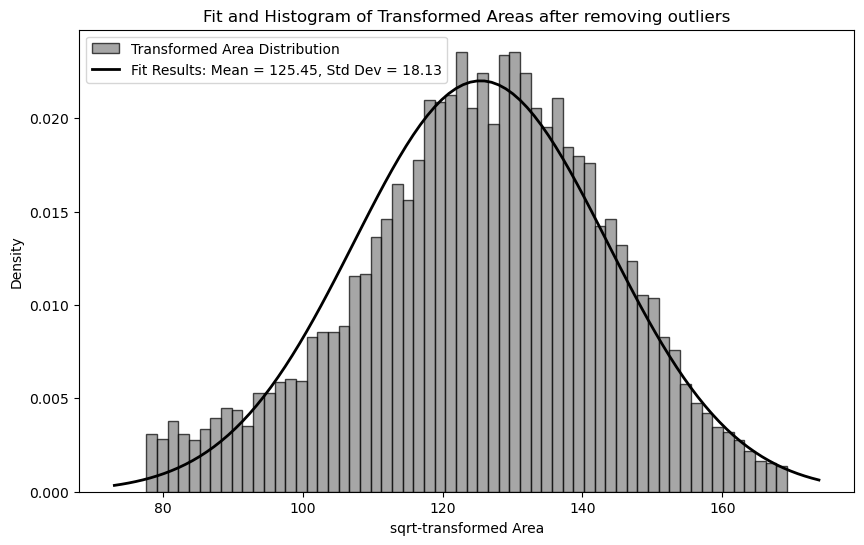

In [12]:
# Plot the distribution of ROI areas in the filtered data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = filtr_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas after removing outliers')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_no-outliers.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [13]:
# Merge Plasmid Type and Concentration to existing dataframe 

# Define Experimental Groups csv, label "df2"
experimental_groups = '/Users/tg2684/Downloads/DIMMERs/microscope-data/08052024_pDIMMERs/experimental-groups.csv'
df2 = pd.read_csv(experimental_groups)

# Join previous data frame with df2
joined_df = pd.merge(filtr_metrics_df, df2, left_on='filename', right_on='filename', how='left')
print(joined_df.head())

   image_index                                           filename  \
0            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
1            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
2            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
3            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   
4            0  05082024_pDIMMERs_pDIMMER_EGFP_TLP1c_miR-Lx2_m...   

          experiment  ROI_index  channel   area          avg  median  \
0  08052024_pDIMMERs          1        0  17382  3302.437809  3106.0   
1  08052024_pDIMMERs          1        1  17382   324.945173   324.0   
2  08052024_pDIMMERs          1        2  17382   365.123979   351.0   
3  08052024_pDIMMERs          2        0  13111  3742.484860  3711.0   
4  08052024_pDIMMERs          2        1  13111   301.694989   296.0   

          std  maxima  minima     tx_area  experiment_folder  \
0  645.590364    7195    2037  131.840813  08052024_pDIMMERs   
1   17.322110     488   

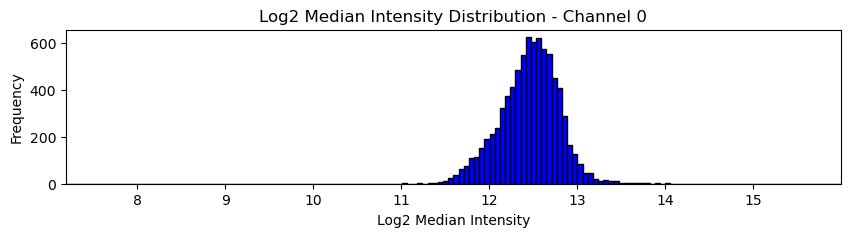

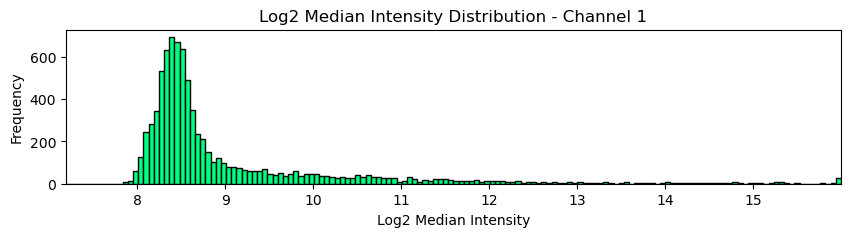

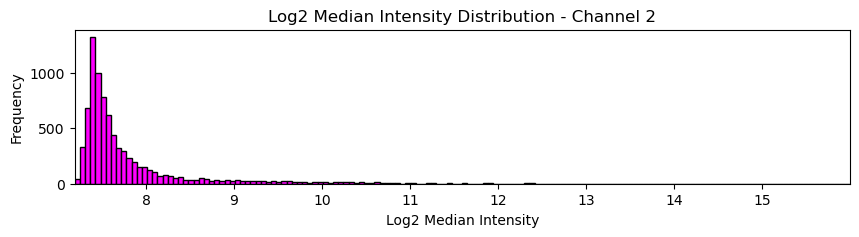

In [14]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Transform the metric values to log2
metrics_df['log2_median'] = np.log2(metrics_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metrics_df['log2_median'].min()
global_max_intensity = metrics_df['log2_median'].max()
max_frequency = metrics_df.groupby('channel')[my_metric].count().max()

# Define channel colors
channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in metrics_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize = (10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins = 150, 
                               color = channel_colors.get(channel, 'gray'), 
                               edgecolor = 'black', 
                               linewidth = 1, 
                               #density = True, 
                               range = (global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    #plt.ylim(0, max_frequency)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()

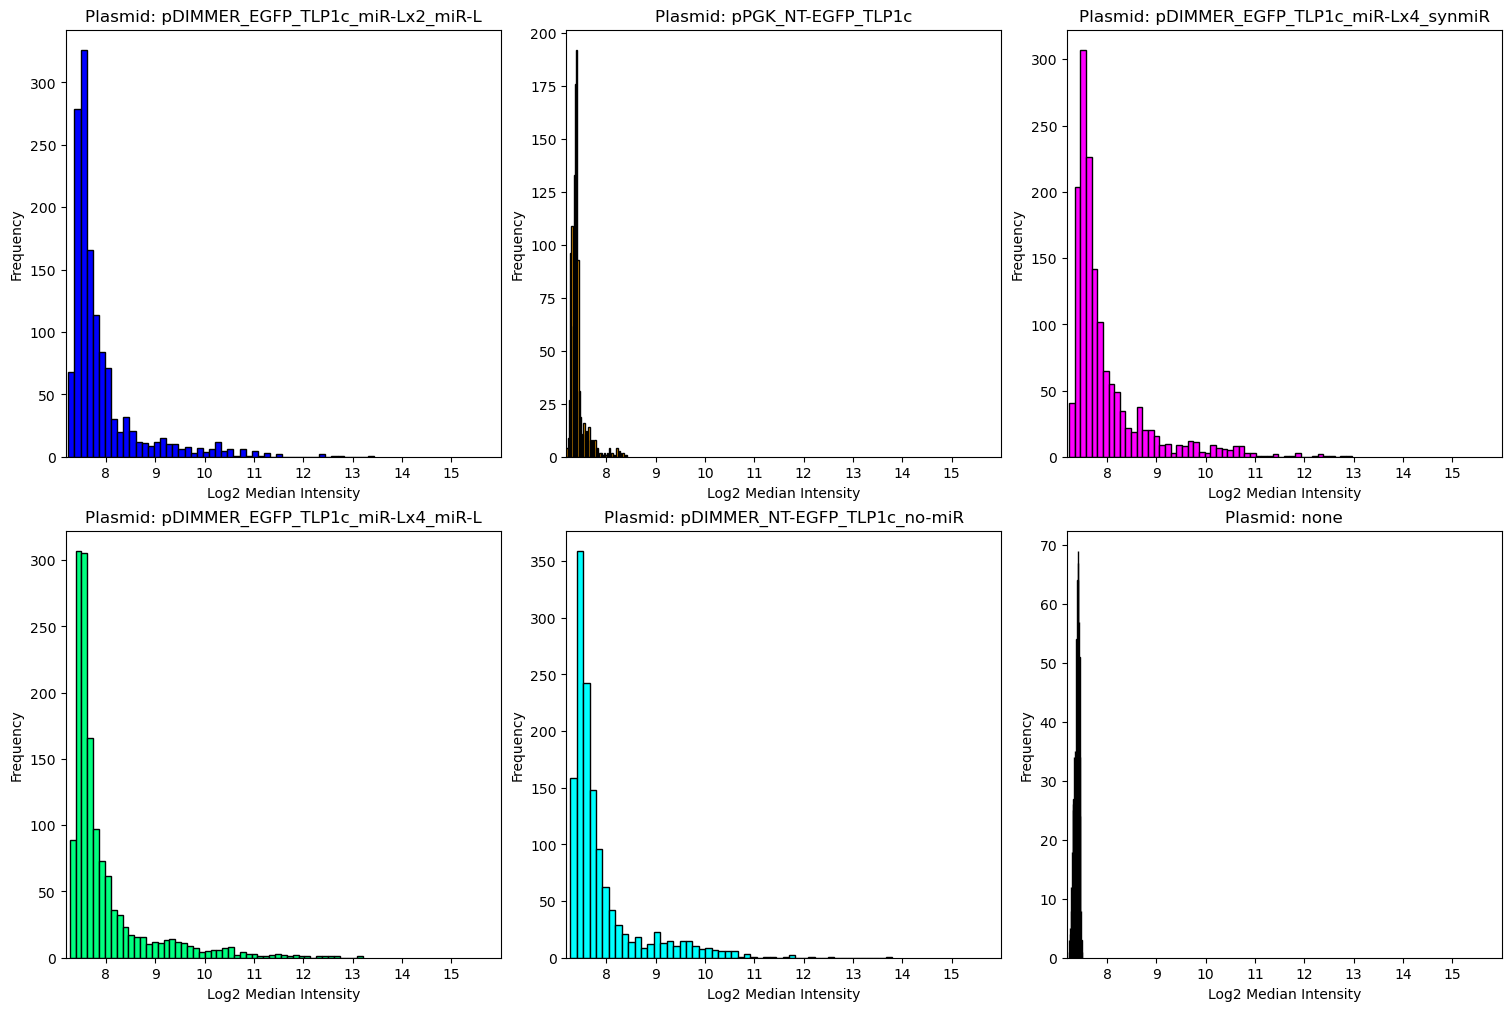

In [15]:
# Choose the channel and metric to plot
channel_to_plot = 2
my_metric = 'median'
x_label = "Median Intensity"

# Apply log2 transformation
joined_df['log2_median'] = np.log2(joined_df[my_metric])

# Define colors for each plasmid type
plasmid_colors = {
    'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L': 'blue',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L': 'springgreen',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR': 'magenta',
    'pDIMMER_NT-EGFP_TLP1c_no-miR': 'cyan',
    'pPGK_NT-EGFP_TLP1c': 'orange',
    'none': 'gray'
}

# Extract unique plasmid types from the DataFrame
plasmids = joined_df['plasmid'].unique() 

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = joined_df['log2_median'].min()
global_max_intensity = joined_df['log2_median'].max()
max_frequency = joined_df[joined_df['channel'] == channel_to_plot].groupby('plasmid')['log2_median'].count().max()

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

# Plot histograms for each plasmid type
for i, plasmid in enumerate(plasmids):
    # Filter data for the specific plasmid and channel
    filtered_data = joined_df[(joined_df['plasmid'] == plasmid) & (joined_df['channel'] == channel_to_plot)]

    # Plot histogram
    ax = axes[i]
    ax.hist(filtered_data['log2_median'], bins=50, 
            color=plasmid_colors.get(plasmid, 'gray'), 
            edgecolor='black', 
            linewidth=1)
    ax.set_title(f'Plasmid: {plasmid}')
    ax.set_xlabel(f'Log2 {x_label}')
    ax.set_ylabel('Frequency')
    ax.set_xlim(global_min_intensity, global_max_intensity)
   # ax.set_ylim(0, max_frequency)
    ax.grid(False)  # Optionally turn off the grid

# Hide any unused subplots (if any)
for j in range(len(plasmids), len(axes)):
    axes[j].axis('off')

plt.show()


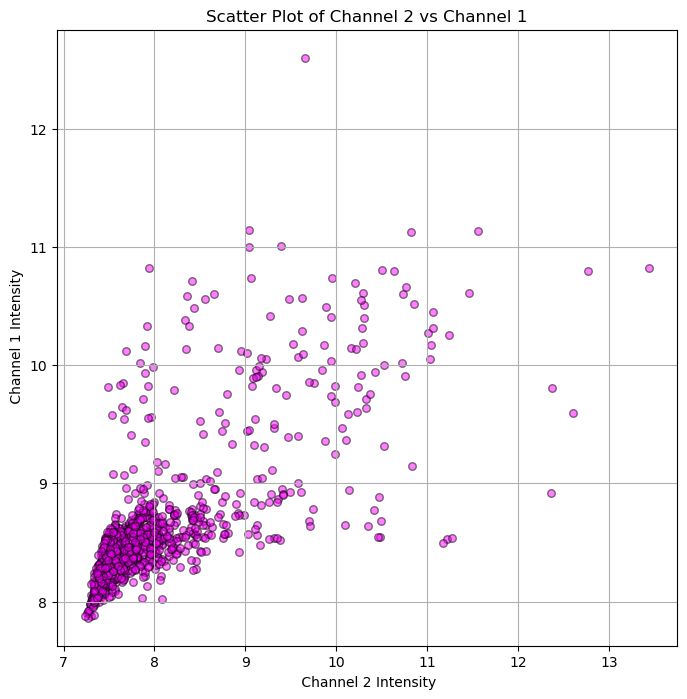

In [16]:
# Now we have to do stuff 

# Apply the initial filter based on FileName and Concentration
filtered_metrics_df = joined_df[(joined_df['plasmid'].str.contains('pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L')) & (joined_df['amount'] == '250 ng')]

# Toggle channels for Scatter Plot 
channel_x = 2
channel_y = 1

# Filter data for the chosen channels within the already filtered DataFrame
data_x = filtered_metrics_df[filtered_metrics_df['channel'] == channel_x]
data_y = filtered_metrics_df[filtered_metrics_df['channel'] == channel_y]

# Ensure both dataframes have the same index for merging
data_x = data_x.reset_index(drop=True)
data_y = data_y.reset_index(drop=True)

# Apply log2 transformation to the median values
data_x['log2_median'] = np.log2(data_x['median'])
data_y['log2_median'] = np.log2(data_y['median'])

# Combine the data for scatter plot
combined_df = pd.concat([data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}), 
                          data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)

# Plot scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(combined_df['x_intensity'], combined_df['y_intensity'],
            color='magenta', edgecolor='black', alpha=0.5, s=30)
plt.title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}')
plt.xlabel(f' Channel {channel_x} Intensity')
plt.ylabel(f' Channel {channel_y} Intensity')
plt.grid(True)
plt.show()

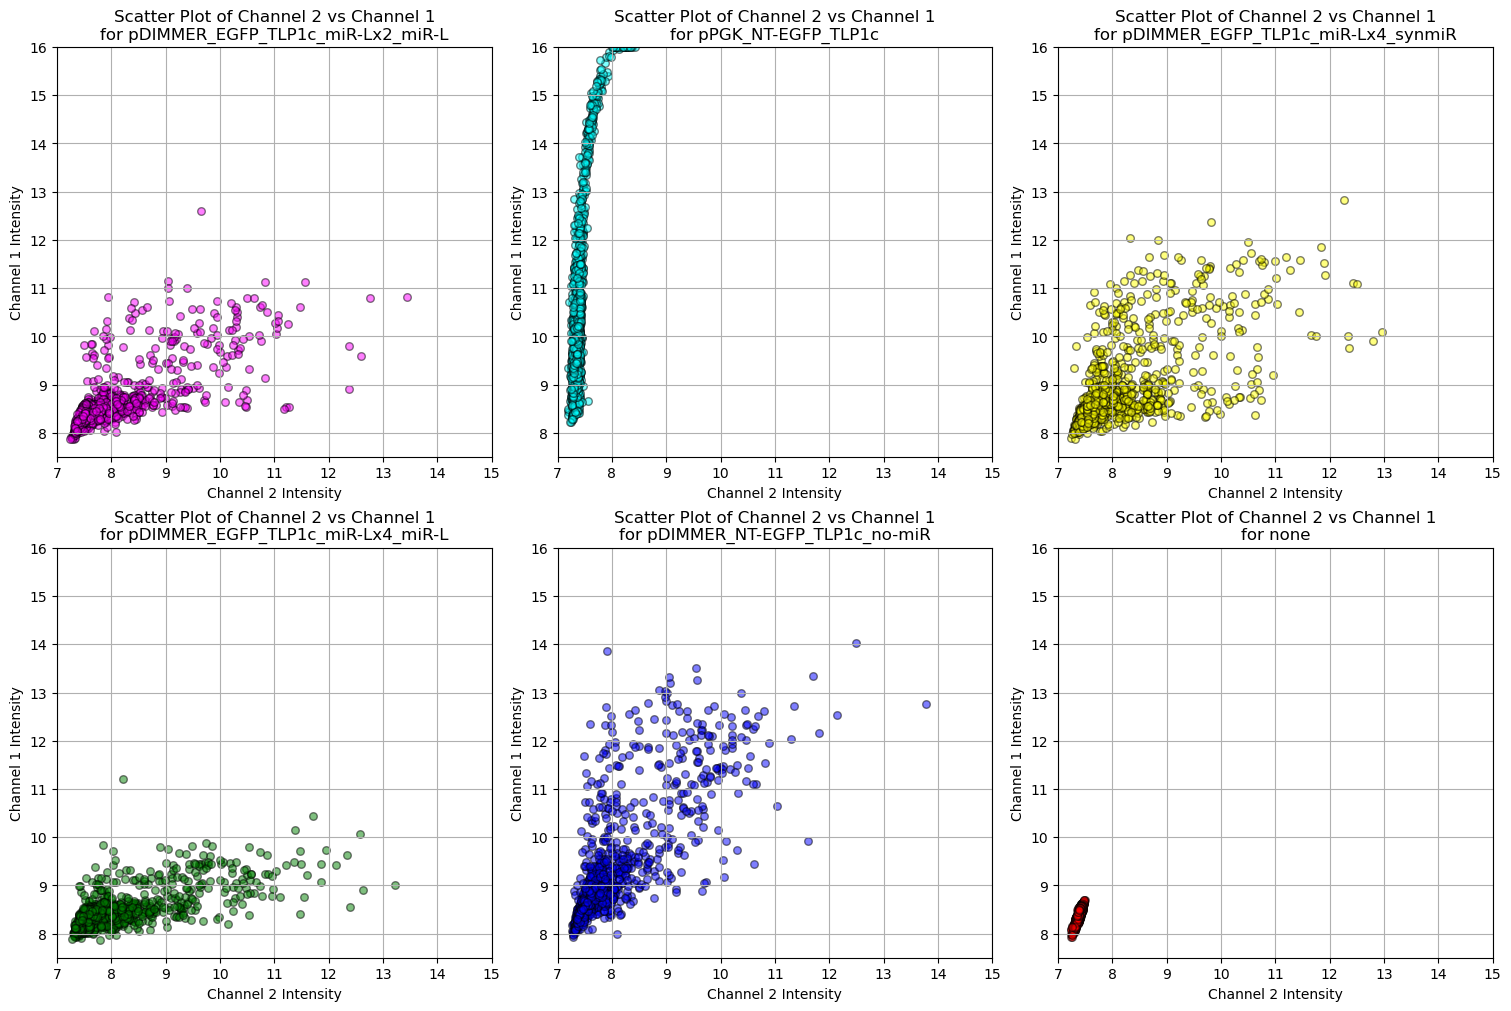

In [17]:
# Example dataframe (make sure to replace this with your actual dataframe)


# Toggle channels for Scatter Plot
channel_x = 2
channel_y = 1


# Extract unique plasmid types from the DataFrame
plasmids = joined_df['plasmid'].unique() 

# Create a grid layout for subplots
num_plasmids = len(plasmids)
cols = 3  # Number of columns
rows = (num_plasmids + cols - 1) // cols  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Define a list of colors for the subplots
colors = ['magenta', 'cyan', 'yellow', 'green', 'blue', 'red'] 


# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define fixed axis limits and intervals
x_max = 15 
x_interval = 1

y_max = 16
y_interval = 1  # Interval for y-axis ticks


for i, plasmid in enumerate(plasmids):
    # Apply the filter based on plasmid and concentration
    filtered_metrics_df = joined_df[(joined_df['plasmid'] == plasmid)]

    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_metrics_df[filtered_metrics_df['channel'] == channel_x]
    data_y = filtered_metrics_df[filtered_metrics_df['channel'] == channel_y]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the median values
    data_x['log2_median'] = np.log2(data_x['median'])
    data_y['log2_median'] = np.log2(data_y['median'])

    # Combine the data for scatter plot
    combined_df = pd.concat([data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}), 
                             data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)

    # Plot scatter plot
    ax = axes[i]
    ax.scatter(combined_df['x_intensity'], combined_df['y_intensity'],
               color=colors[i % len(colors)], edgecolor='black', alpha=0.5, s=30)
    ax.set_title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}\nfor {plasmid}')
    ax.set_xlabel(f'Channel {channel_x} Intensity')
    ax.set_ylabel(f'Channel {channel_y} Intensity')
    ax.grid(True)

 # Set x-axis limits and y-axis limits with intervals
    
    ax.set_xlim([7, x_max])
    ax.set_ylim([7.5, y_max])
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_interval)) 
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_interval)) 

# Hide any unused subplots
for j in range(num_plasmids, len(axes)):
    axes[j].axis('off')

plt.show()

Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L: 487
Number of points within threshold for pPGK_NT-EGFP_TLP1c: 83
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR: 453
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L: 491
Number of points within threshold for pDIMMER_NT-EGFP_TLP1c_no-miR: 505
Number of points within threshold for none: 846


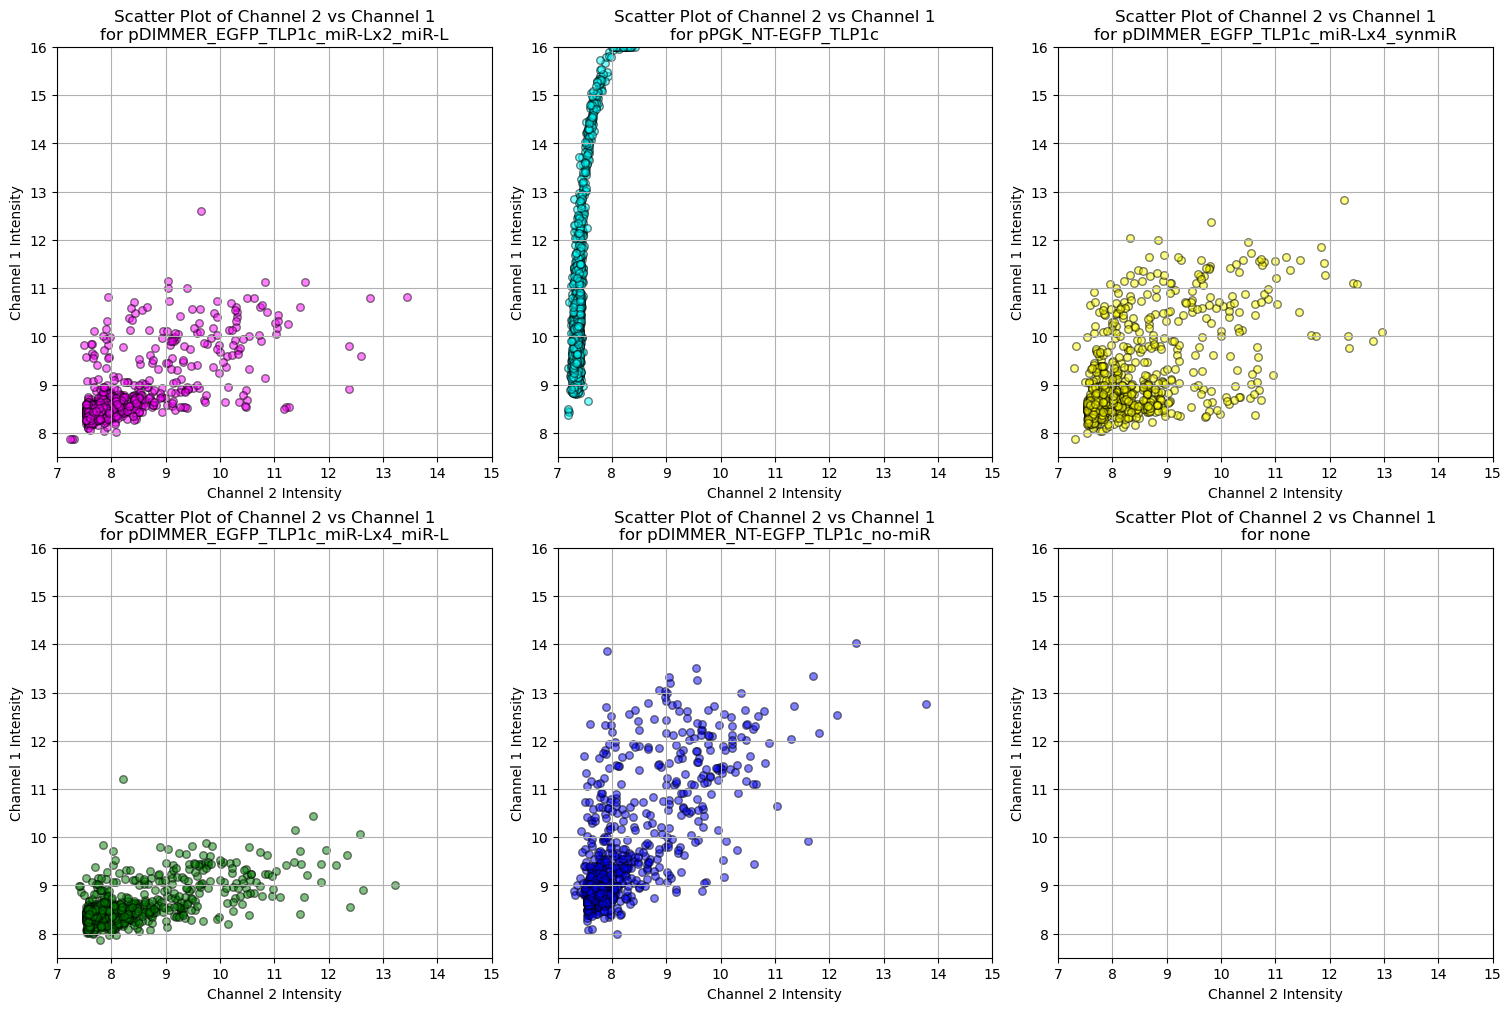

In [18]:
# Toggle channels for Scatter Plot
channel_x = 2
channel_y = 1

# Calculate the statistics for the "none" group for each channel
none_group = joined_df[joined_df['plasmid'] == 'none']

none_mean_x = none_group[none_group['channel'] == channel_x]['median'].mean()
none_std_x = none_group[none_group['channel'] == channel_x]['median'].std()
none_mean_y = none_group[none_group['channel'] == channel_y]['median'].mean()
none_std_y = none_group[none_group['channel'] == channel_y]['median'].std()

# Define the range as mean ± 3 * standard deviation (you can adjust this threshold)
threshold_low_x = none_mean_x - 3 * none_std_x
threshold_high_x = none_mean_x + 3 * none_std_x
threshold_low_y = none_mean_y - 3 * none_std_y
threshold_high_y = none_mean_y + 3 * none_std_y


# Extract unique plasmid types from the DataFrame
plasmids = joined_df['plasmid'].unique()

# Create a grid layout for subplots
num_plasmids = len(plasmids)
cols = 3  # Number of columns
rows = (num_plasmids + cols - 1) // cols  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Define a list of colors for the subplots
colors = ['magenta', 'cyan', 'yellow', 'green', 'blue', 'red']

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define fixed axis limits and intervals
x_max = 15 
x_interval = 1
y_max = 16
y_interval = 1  # Interval for y-axis ticks

for i, plasmid in enumerate(plasmids):
    # Apply the filter based on plasmid
    filtered_metrics_df = joined_df[(joined_df['plasmid'] == plasmid)]

    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_metrics_df[filtered_metrics_df['channel'] == channel_x]
    data_y = filtered_metrics_df[filtered_metrics_df['channel'] == channel_y]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the median values
    data_x['log2_median'] = np.log2(data_x['median'])
    data_y['log2_median'] = np.log2(data_y['median'])

    # Combine the data for scatter plot
    combined_df = pd.concat([data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}), 
                             data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)


    # Check if the points fall within the threshold before filtering
    within_threshold = (combined_df['x_intensity'] >= np.log2(threshold_low_x)) & (combined_df['x_intensity'] <= np.log2(threshold_high_x)) & \
                       (combined_df['y_intensity'] >= np.log2(threshold_low_y)) & (combined_df['y_intensity'] <= np.log2(threshold_high_y))
    print(f"Number of points within threshold for {plasmid}: {within_threshold.sum()}")

    # Filter out points that fall within the defined range of the "none" group
    filtered_combined_df = combined_df[~within_threshold]

    # Plot scatter plot
    ax = axes[i]
    ax.scatter(filtered_combined_df['x_intensity'], filtered_combined_df['y_intensity'],
               color=colors[i % len(colors)], edgecolor='black', alpha=0.5, s=30)
    ax.set_title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}\nfor {plasmid}')
    ax.set_xlabel(f'Channel {channel_x} Intensity')
    ax.set_ylabel(f'Channel {channel_y} Intensity')
    ax.grid(True)

    # Set x-axis limits and y-axis limits with intervals
    ax.set_xlim([7, x_max])
    ax.set_ylim([7.5, y_max])
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_interval)) 
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_interval)) 

# Hide any unused subplots
for j in range(num_plasmids, len(axes)):
    axes[j].axis('off')

plt.show()

/var/folders/tf/f1_wyw0x3pb52tmwg0143_gx9sr5bl/T/ipykernel_95843/296520213.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='plasmid', y='log2_median', data=filtered_df, palette='Set2', order=plasmid_order)


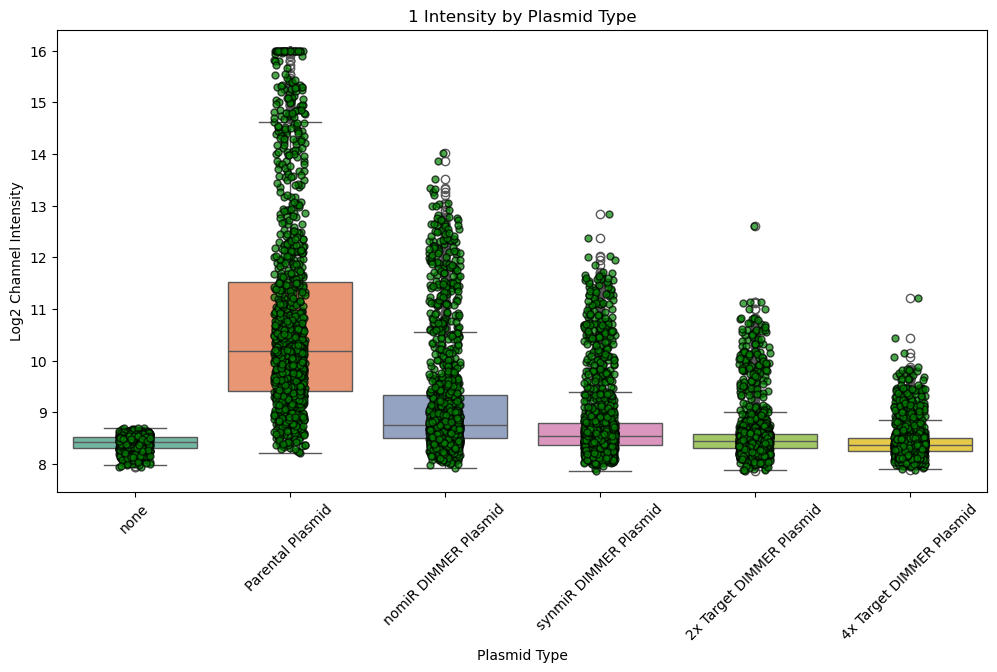

In [19]:
# Define the channel you want to plot on the y-axis for the box plot
channel_to_plot = 1  # Change this to the desired channel

# Filter the DataFrame for the selected channel
filtered_df = joined_df[joined_df['channel'] == channel_to_plot].copy()

# Apply log2 transformation to the median intensity
filtered_df.loc[:, 'log2_median'] = np.log2(filtered_df['median'])

# Create the box plot with jittered points
plt.figure(figsize=(12, 6))

# Define the order of plasmid types
plasmid_order = ['none', 'pPGK_NT-EGFP_TLP1c', 'pDIMMER_NT-EGFP_TLP1c_no-miR', 'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR', 'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L', 'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L']  # Replace with actual plasmid types in desired order

# Create the box plot
sns.boxplot(x='plasmid', y='log2_median', data=filtered_df, palette='Set2', order=plasmid_order)

# Add jittered points with custom color and outline
sns.stripplot(x='plasmid', y='log2_median', data=filtered_df, 
              color='green',  # Color of the jitter points
              edgecolor='black',  # Outline color
              linewidth=1,  # Outline width
              alpha=0.7,  # Transparency of the points
              jitter=True, 
              dodge=True,
              order=plasmid_order)

# Add titles andlabels
plt.title(f'{channel_to_plot} Intensity by Plasmid Type')
plt.xlabel('Plasmid Type')
plt.ylabel('Log2 Channel Intensity')

# Define custom labels for the x-axis
custom_labels = {
    'none': 'none',
    'pPGK_NT-EGFP_TLP1c': 'Parental Plasmid',
    'pDIMMER_NT-EGFP_TLP1c_no-miR': 'nomiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR': 'synmiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L': '2x Target DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L': '4x Target DIMMER Plasmid',
    # Add more mappings as needed
}

# Update x-axis labels with custom labels
plt.xticks(ticks=range(len(plasmid_order)), labels=[custom_labels.get(label, label) for label in plasmid_order], rotation=45)

# Show plot
plt.show()

In [ ]:

# Assume average_background_intensity is calculated as shown above

# Apply the initial filter based on FileName and Concentration
filtered_metrics_df = joined_df[(joined_df['filename'].str.contains('pDIMMER_NT-EGFP_TLP1c')) & (joined_df['amount'] == '250ng')]

# Define channel pairs and corresponding colors
channel_pairs = [(2, 1), (0, 1), (0, 2)]
colors = ['brown', 'teal', 'purple']

# Create subplots with a larger figure size
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
fig.suptitle('Scatter Plots of Channel Pairs', fontsize=20)

for i, (channel_x, channel_y) in enumerate(channel_pairs):
    color = colors[i]
    ax = axes[i]
    
    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_metrics_df[filtered_metrics_df['channel'] == channel_x].copy()
    data_y = filtered_metrics_df[filtered_metrics_df['channel'] == channel_y].copy()

    # Apply background subtraction using the average background intensity for the respective channels
    data_x.loc[:, 'bg_subtracted_median'] = data_x['median'] - average_background_intensity[channel_x]
    data_y.loc[:, 'bg_subtracted_median'] = data_y['median'] - average_background_intensity[channel_y]

    # Filter out negative or zero values
    data_x = data_x[data_x['bg_subtracted_median'] > 0]
    data_y = data_y[data_y['bg_subtracted_median'] > 0]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the background-subtracted median values with a small constant to avoid log2(0)
    data_x['log2_median'] = np.log2(data_x['bg_subtracted_median'] + 1)
    data_y['log2_median'] = np.log2(data_y['bg_subtracted_median'] + 1)

    # Combine the data for scatter plot
    combined_df = pd.concat([
        data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}),
        data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})
    ], axis=1)

    # Plot scatter plot with specified color
    ax.scatter(combined_df['x_intensity'], combined_df['y_intensity'],
               color=color, edgecolor='black', alpha=0.7, s=50)
    
    # Add linear trend line to the first subplot (channel pair (2, 1))
    if (channel_x, channel_y) == (2, 1):
        # Calculate the linear fit
        coefficients = np.polyfit(combined_df['x_intensity'], combined_df['y_intensity'], 1)
        poly = np.poly1d(coefficients)
        x_range = np.linspace(combined_df['x_intensity'].min(), combined_df['x_intensity'].max(), 100)
        trend_line = poly(x_range)

        # Plot the trend line
        ax.plot(x_range, trend_line, color='red', linestyle='--', linewidth=2, label='Trend Line')

    ax.set_title(f'Channel {channel_x} vs Channel {channel_y}', fontsize=16)
    ax.set_xlabel(f'Channel {channel_x} Intensity', fontsize=14)
    ax.set_ylabel(f'Channel {channel_y} Intensity', fontsize=14)
    ax.grid(True)
    
    # Add legend to the first subplot
    if (channel_x, channel_y) == (2, 1):
        ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
